C:\Users\ALrig\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ALrig\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ALrig\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ALrig\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

Best ARIMA order: (0, 0, 0)


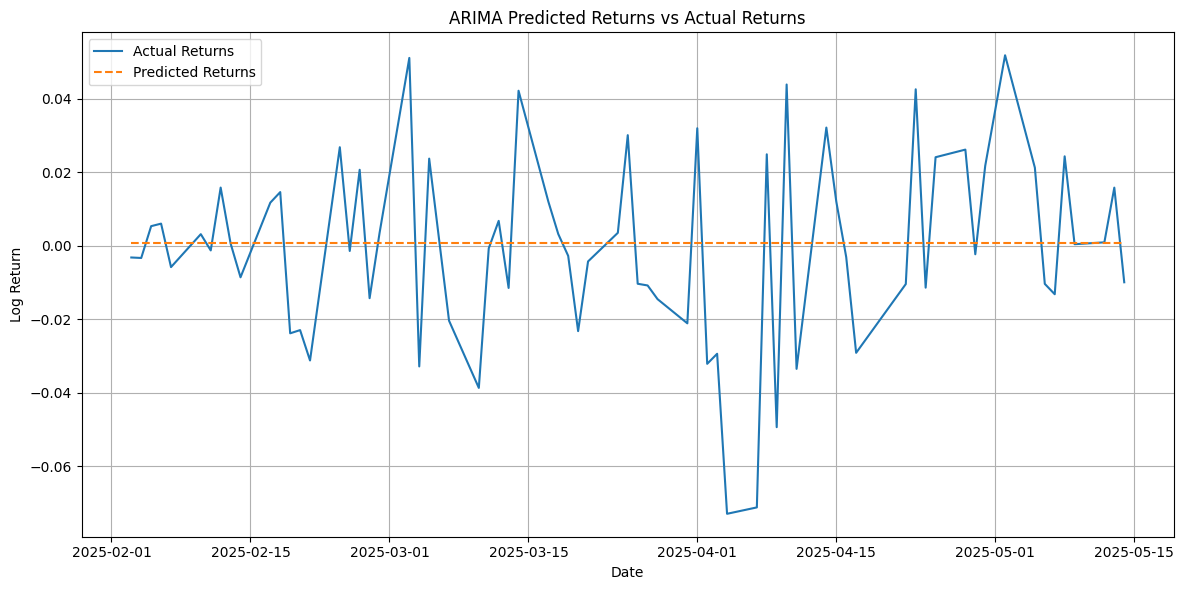

Mean Squared Error: 0.000636


In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

def select_best_arima(train, max_p=3, max_d=2, max_q=3):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except:
                    continue
    return best_order, best_model

def predict_return_arima(ticker: str, start_date: str, end_date: str):
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df['Return'] = np.log(df['Close']).diff()
    df = df.dropna()

    split_idx = int(len(df) * 0.8)
    train, test = df['Return'].iloc[:split_idx], df['Return'].iloc[split_idx:]

    best_order, best_model = select_best_arima(train)
    print(f"Best ARIMA order: {best_order}")

    forecast = best_model.forecast(steps=len(test))
    mse = mean_squared_error(test, forecast)

    return train, test, forecast, mse

def plot_returns(real, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(real.index, real, label='Actual Returns')
    plt.plot(real.index, predicted, label='Predicted Returns', linestyle='--')
    plt.legend()
    plt.title("ARIMA Predicted Returns vs Actual Returns")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Utilisation
train, test, forecast, mse = predict_return_arima('AIR.PA', '2024-01-01', '2025-05-15')
plot_returns(test, forecast)
print(f"Mean Squared Error: {mse:.6f}")

In [20]:
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import pandas as pd
import numpy as np

# Téléchargement et prétraitement
df = yf.download('AIR.PA', start='2024-01-01', end='2025-05-15', progress=False)
df = df[['Close']].dropna()

if isinstance(df.columns, pd.MultiIndex):
    df = df["Close"]['AIR.PA']
else:
    df = df["Close"]

df = df.sort_index().to_frame(name="price")
df = df.asfreq('B').fillna(method='ffill')

# Calcul des returns
df['Return'] = np.log(df['price']).diff()

# Supprimer tous les NaN et valeurs infinies
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Test ADF
result = adfuller(df['Return'])
print("ADF p-value:", result[1])

ADF p-value: 7.364039568981561e-21


C:\Users\ALrig\AppData\Local\Temp\ipykernel_14852\100406730.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq('B').fillna(method='ffill')


In [93]:
import yfinance as yf
import numpy as np
def create_features_dataframe(ticker: str, start_date:str, end_date:str): 
    df = yf.download(ticker, start_date, end_date, progress=False)
    df = df[["Close"]]
    df.columns = ["Close"]
    df["return_t+1"] = np.log(df["Close"].shift(-1) / df["Close"])
    df["return_t"] = np.log(df["Close"] / df["Close"].shift(1))
    df["sma_5"] = df["Close"].rolling(window=5).mean()
    df.dropna()
    return df

df = create_features_dataframe('AIR.PA', '2024-03-01', '2024-10-01')


C:\Users\ALrig\AppData\Local\Temp\ipykernel_25880\1019856207.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


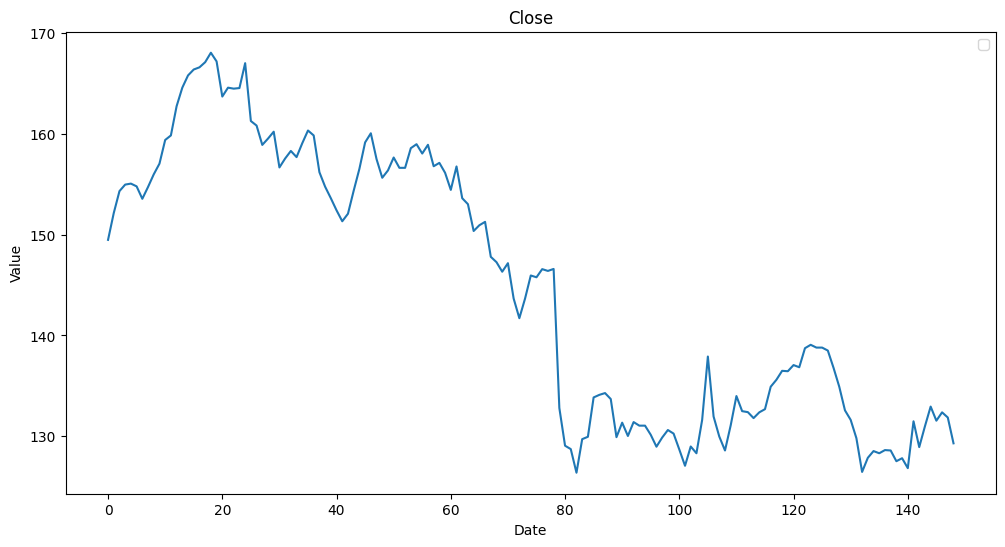

In [94]:
import matplotlib.pyplot as plt
def plot_serie(df):
    plt.figure(figsize=(12,6))
    plt.plot(df['Close'].values)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Close")
    plt.legend()
    plt.show()

plot_serie(df)

In [95]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def predict_gbt_returns(df, window):
    if 'return_t+1' not in df.columns:
        raise ValueError("The DataFrame must contain a 'return_t+1' column.")

    features = [col for col in df.columns if col != 'return_t+1'] 
    predictions = []
    actuals = []
    index = []

    for t in range(window, len(df)):
        X_train = df[features].iloc[t - window:t]
        y_train = df['return_t+1'].iloc[t - window:t]

        X_pred = df[features].iloc[t:t+1]
        y_true = df['return_t+1'].iloc[t]

        if X_train.isnull().values.any() or X_pred.isnull().values.any() or pd.isna(y_true):
            continue

        model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_pred)[0]

        predictions.append(y_pred)
        actuals.append(y_true)
        index.append(df.index[t])

    return pd.DataFrame({
        "predict_return_t": predictions,
        "return_t": actuals
    }, index=index)

df_predict = predict_gbt_returns(df, 15)

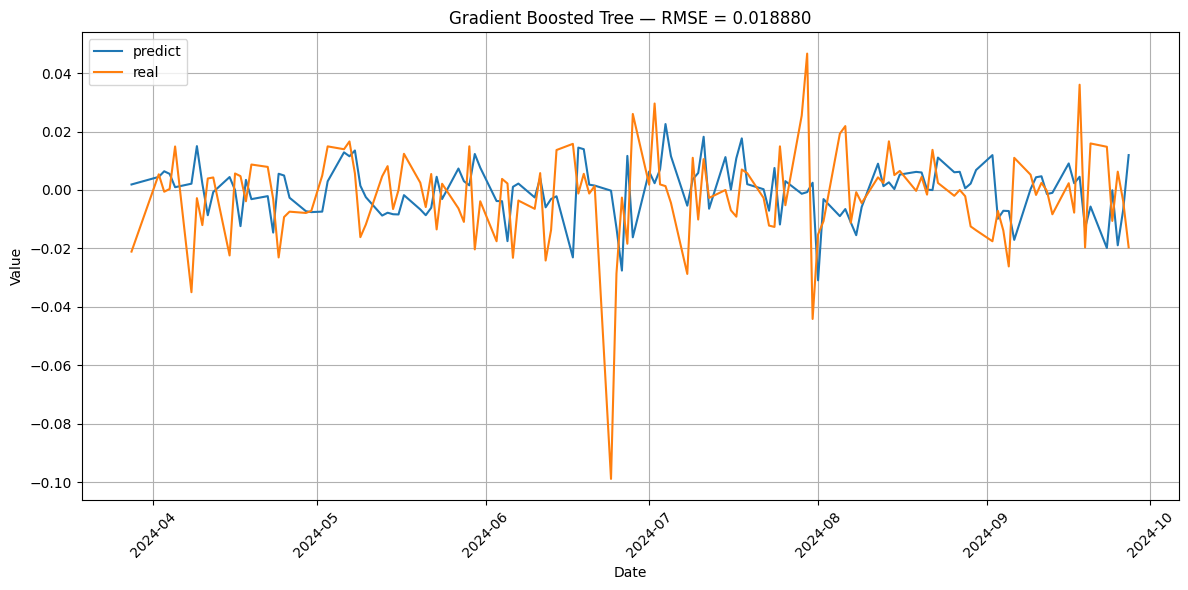

In [96]:
import matplotlib.pyplot as plt

def plot_two_series(df1, df2, label_model, label1='predict', label2='real'):
    if not df1.index.equals(df2.index):
        raise ValueError("DataFrames must have the same index.")
    if df1.shape != df2.shape:
        raise ValueError("DataFrames must have the same shape.")
    y_pred = df1.values.flatten()
    y_true = df2.values.flatten()

    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    plt.figure(figsize=(12, 6))
    plt.plot(df1.index, y_pred, label=label1)
    plt.plot(df2.index, y_true, label=label2)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"{label_model} — RMSE = {rmse:.6f}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_two_series(df_predict['predict_return_t'], df_predict['return_t'], "Gradient Boosted Tree")

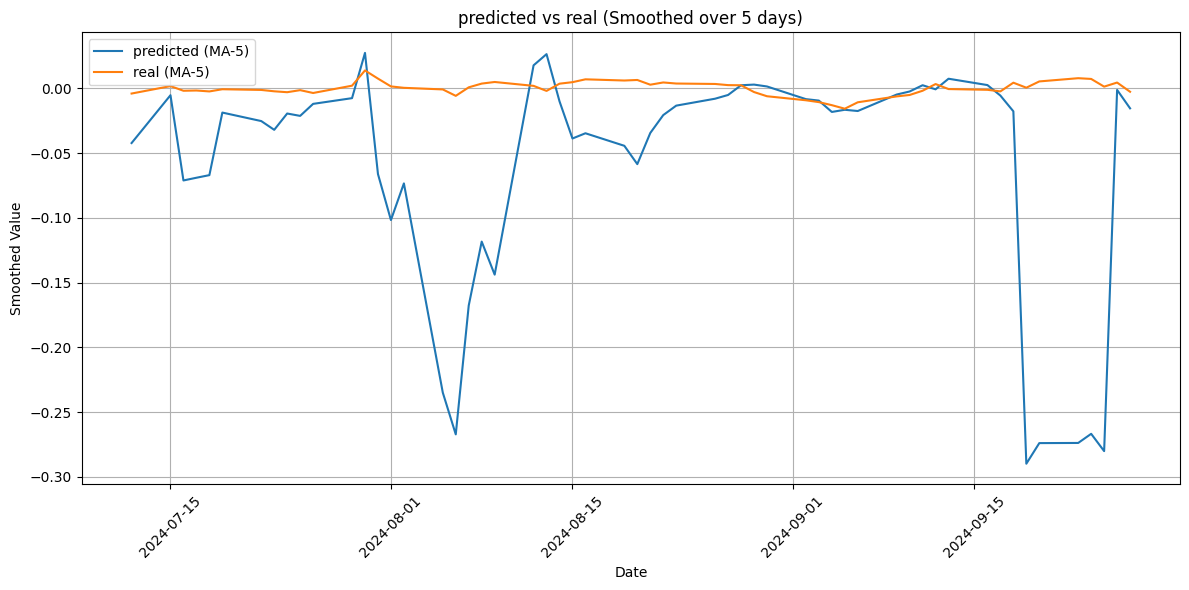

In [18]:
import matplotlib.pyplot as plt

def plot_smoothed_series(df1, df2, label1='predicted', label2='real', window=5):
    if not df1.index.equals(df2.index):
        raise ValueError("DataFrames must have the same index.")

    smooth1 = df1.rolling(window=window).mean()
    smooth2 = df2.rolling(window=window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(smooth1, label=f"{label1} (MA-{window})")
    plt.plot(smooth2, label=f"{label2} (MA-{window})")
    plt.xlabel("Date")
    plt.ylabel("Smoothed Value")
    plt.title(f"{label1} vs {label2} (Smoothed over {window} days)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_smoothed_series(df_predict['predict_return_t'], df_predict['return_t'])